# Прогнозирование оттока действующих клиентов банка

На основе исторческих данных о поведении клиентов и расторжении договоров с банком спрогнозировать уйдёт клиент из банка в ближайшее время или нет.

Целевая метрика *F1*. Дополнительная метрика *AUC-ROC*.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Описание данных

##### Признаки
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — количество недвижимости у клиента  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  
##### Целевой признак  
Exited — факт ухода клиента  

# Структура проекта:
[1. Подготовка данных](#1)  
[2. Исследование задачи](#2)    
   [2.1 Анализ данных](#2.1)  
   [2.2 Работа с пропусками](#2.2)  
[3. Подготовка моделей](#3)    
   [3.1 Кодирование](#3.1)    
   [3.2 Деление на выборки](#3.2)    
[4. Моделирование](#4)  
       [4.1 Дерево решений](#4.1)  
       [4.1.1 Несбалансированная модель](#4.1.1)  
       [4.1.2 Балансированная модель](#4.1.2)  
       [4.1.3 Визуализация модели](#4.1.3)  
   [4.2 Случайный лес](#4.2)  
       [4.2.1 Несбалансированная модель](#4.2.1)  
       [4.2.2 Балансированная модель](#4.2.2)  
       [4.2.3 Визуализация модели](#4.2.3)  
   [4.3 Логистическая регрессия](#4.3)  
       [4.3.1 Несбалансированная модель](#4.3.1)  
       [4.3.2 Балансированная модель](#4.3.2)  
   [4.4 Градиентный бустинг](#4.4)  
       [4.4.1 Несбалансированная модель](#4.4.1)  
       [4.4.2 Балансированная модель](#4.4.2)  
   [4.5 Catboost](#4.5)  
       [4.5.1 Несбалансированная модель](#4.5.1)  
       [4.5.2 Балансированная модель](#4.5.2)  
[5. Тестирование модели](#5)    

[Итоговый вывод](#6) 

# <a name="1"> 1. Подготовка данных</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import sklearn.exceptions
warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
!pip install catboost
from catboost import CatBoostClassifier

Defaulting to user installation because normal site-packages is not writeable


- загружаем все необходимые модули.
- загружаю также фильтр информационных ошибок, не меняющих значения расчетов

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


- пропуски в столбце Tenure
- 3 столбца object возможно придется перекодировать 

In [5]:
df.duplicated().sum()

0

## Вывод:
- пропуски в столбце Tenure
- 3 столбца object возможно придется перекодировать 

# <a name="2">2. Исследование задачи</a>

## <a name="2.1">2.1 Анализ данных</a>

In [6]:
df['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

- большой перекос нулей, придется балансировать при расчетах
- 20% клиентов покидают банк

Text(0.5, 1, 'Correlation matrix')

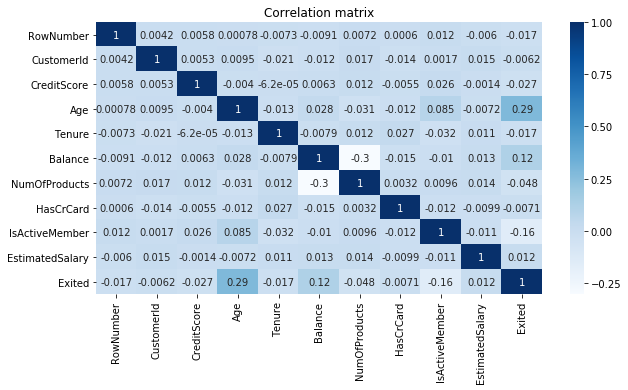

In [7]:
fig, axes = plt.subplots(figsize=(10, 5))
sns.heatmap(df.corr(), cmap="Blues", annot=True, cbar = True).set_title('Correlation matrix')

- На матрице нет сильных корреляционых связей, есть небольшие значения по признакам Age/Exited и NumOfProducts/Balance. 
- Немного непонятна обратную корреляцию по NumOfProducts от признака Balance. Я понимаю чем меньше денег, тем меньше количество продуктов. Но тут почему то наоборот.
- То про Age к Exited немного не пойму, взрослые люди в наше время более консервативны и стараются не менять банки.

- посмотрю есть ли взаимосвязи по Exited по каждой группе

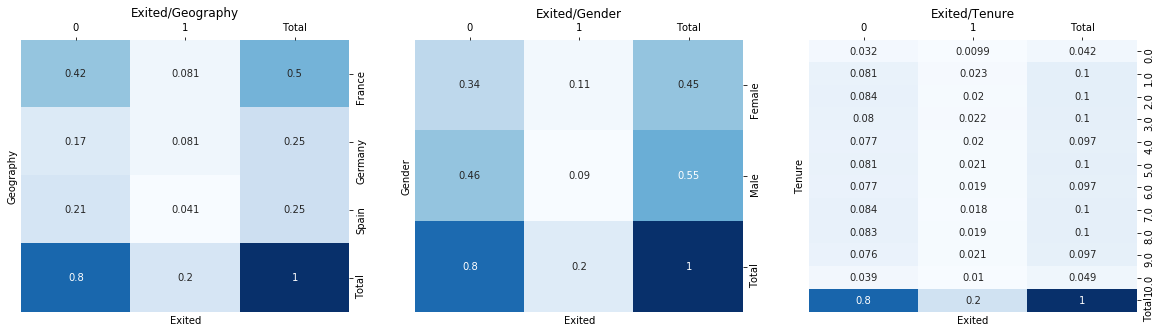

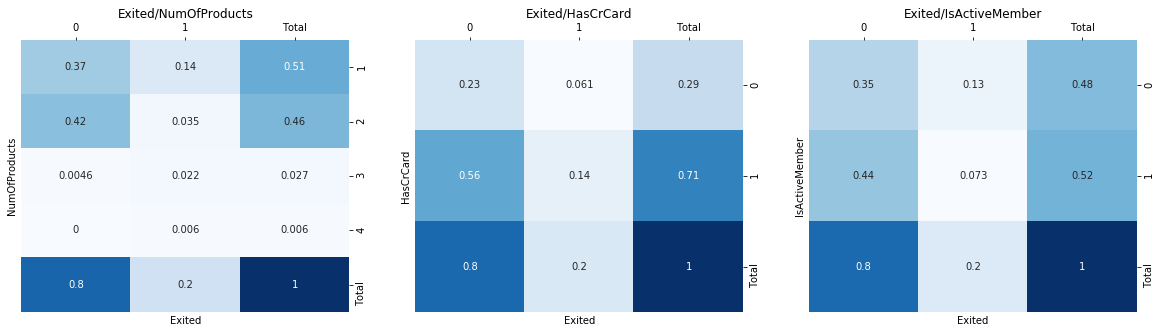

In [8]:
count = 0
for i in df[['Geography', 'Gender','Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']].columns:
      if count == 0:
          fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
      sns.heatmap(pd.crosstab(index = df[i], columns = df['Exited'], margins = True, normalize = True, margins_name="Total"),
            cmap="Blues", annot=True, cbar = False, ax = axes[count]).set_title('Exited/'+i)
      axes[count].xaxis.tick_top()
      axes[count].yaxis.tick_right()
      count += 1
      if count == 3:
            count = 0
#      fig.show()

- 25% клиентов из Германии являются клиентами банка, 32% из которых уходит
- 50% клиентов имеют всего один продукт банка, 28% из которых уходит/все кто имеет 3 или 4 продукта,  уходят с высокой долей  
  вероятности(3пр - 81,5% и 4пр - 100%). Плохое обслуживание?))
- 48% клинетов имеют низкую активность, 27% из которых уходит

In [9]:
df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']].describe()

,CreditScore,Age,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,100090.239881
std,96.653299,10.487806,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,11.580000
25%,584.000000,32.000000,0.000000,51002.110000
50%,652.000000,37.000000,97198.540000,100193.915000
75%,718.000000,44.000000,127644.240000,149388.247500
max,850.000000,92.000000,250898.090000,199992.480000


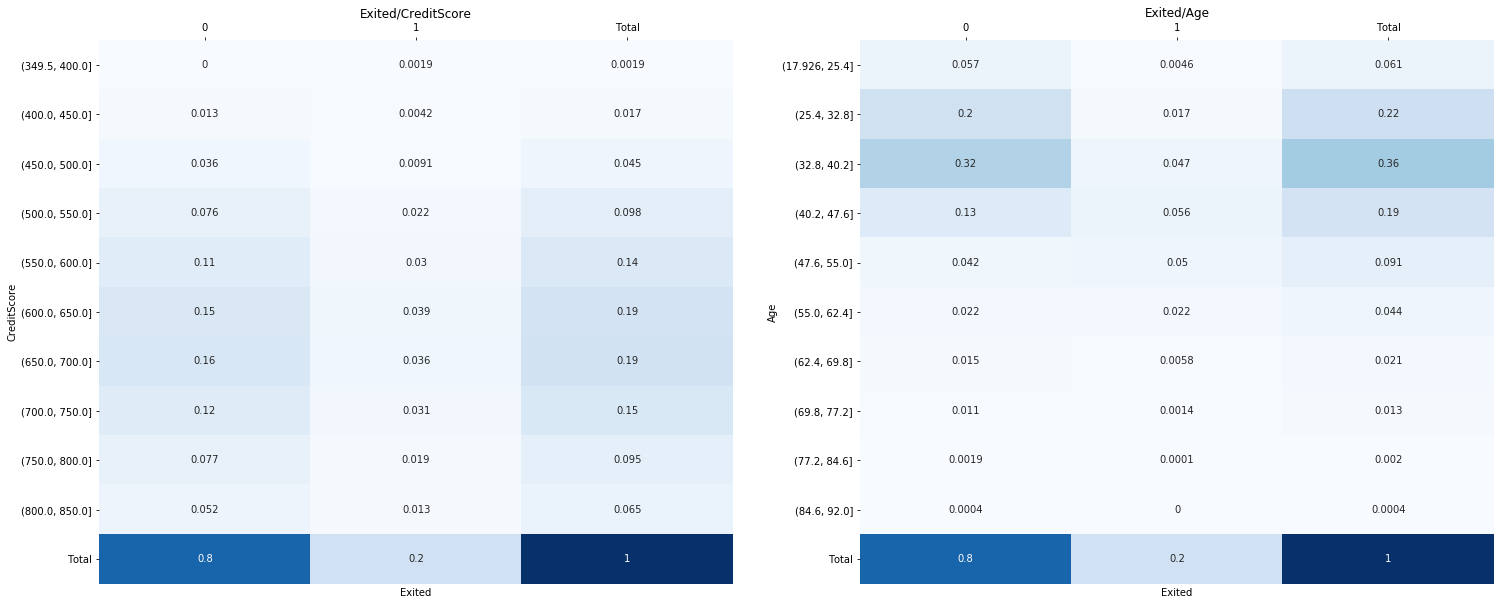

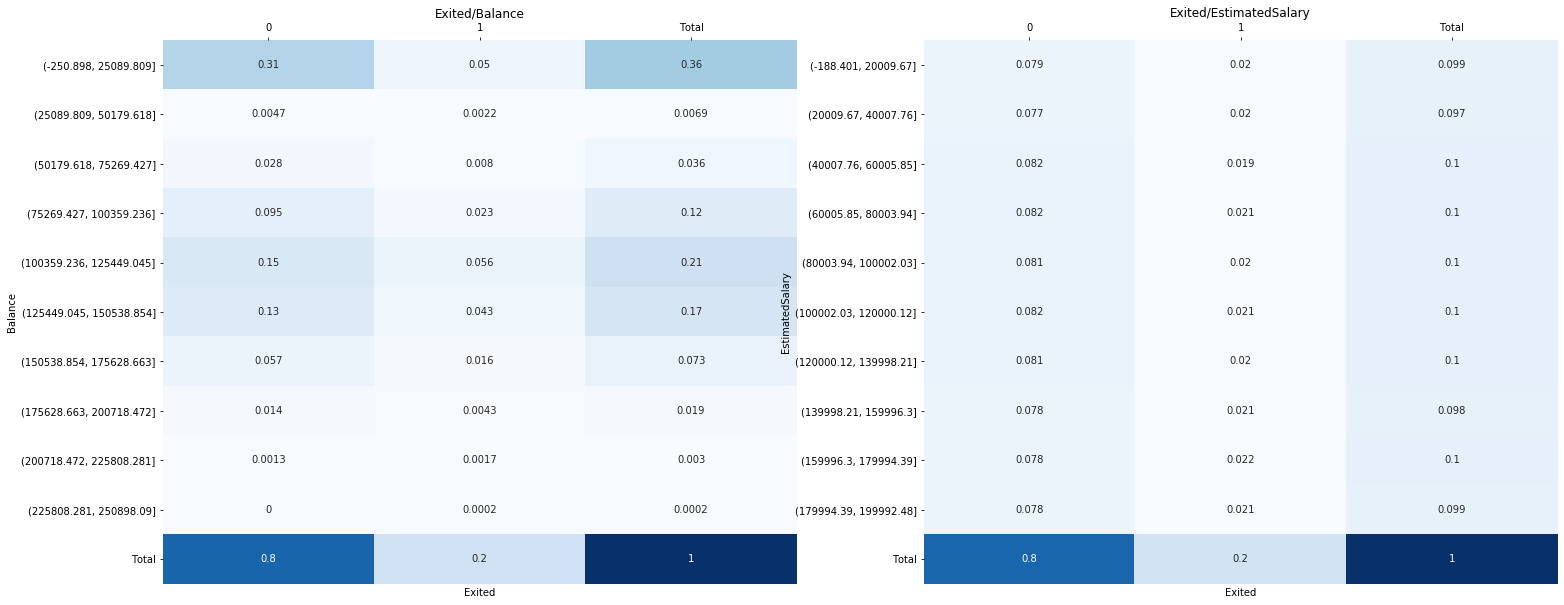

In [10]:
for i in df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']].columns:
      if count == 0:
          fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
      sns.heatmap(pd.crosstab(index = pd.cut(df[i], 10), columns = df['Exited'], margins = True, normalize = True, margins_name="Total"),
            cmap="Blues", annot=True, cbar = False, ax = axes[count]).set_title('Exited/'+i)
      axes[count].xaxis.tick_top()
      count += 1
      if count == 2:
            count = 0
#      fig.show()

- чем ниже кредитный рейтинг у клиента банка, тем вероятность ухода возрастает. У тех клиентов у кого рейтинг от 350 до 400, вероятность ухода составляет 100%. 400-450 уже 25%.
- в возрасте с 25 до 40 клиенты, только 10% клиентов уйдет из банка. В этом возрасте клиенты предпочитают не менять банк.  
  в возрасте от 47 до 62, процент покинувших банк колеблется уже от 50 до 55%.
- 36% всех клиентов имеют баланс 25 тыс., и только 14% из таких клиентов уёдет, далее с возрастаением баланса процент ушедших варьируется между 25-30%
- размер зарплаты никак не влияет на процент ушедших клиентов.

- в таблице есть еще столбец фамилий, есть ли какая то там взаимосвязь и стоит ли его перекодировать

In [11]:
df['Surname'].value_counts(normalize = True)

Smith       0.0032
Martin      0.0029
Scott       0.0029
Walker      0.0028
Brown       0.0026
             ...  
Mashman     0.0001
Munroe      0.0001
Vessels     0.0001
Castella    0.0001
Harrell     0.0001
Name: Surname, Length: 2932, dtype: float64

- Количество уникальных фамилий 2 932, влияние на показатели думаю не имеет. Удалю этот столбец при формировании выборок.

## <a name="2.2">2.2 Работа с пропусками</a>

- В столбце Tenure есть пропуски. Проанализируем.

In [12]:
df['Tenure'].value_counts(dropna = False)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

- по каждому количеству недвижимости приходится примерно от 800 до 900 клиентов
- на 10 только 446, но думаю что это уже связано с тем, что 10 и более, имееют меньшее кол-во клиентов.
- а вот самый частый показатель 0 почему имеет всего 382 записи, я думаю пропуски это нули и заполнб их нулями.

In [13]:
df[df['Tenure'].isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [14]:
df['Tenure'] = df['Tenure'].fillna(0)
df['Tenure'].value_counts(dropna = False)

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: Tenure, dtype: int64

- теперь выглядит более менее правдоподобно

## Вывод:

#### Анализ
- 25% клиентов из Германии являются клиентами банка, 32% из которых уходит
- 50% клиентов имеют всего один продукт банка, 28% из которых уходит/все кто имеет 3 или 4 продукта,  уходят с высокой долей  
  вероятности(3пр - 81,5% и 4пр - 100%). Плохое обслуживание?))
- 48% клинетов имеют низкую активность, 27% из которых уходит
- чем ниже кредитный рейтинг у клиента банка, тем вероятность ухода возрастает. У тех клиентов у кого рейтинг от 350 до 400, вероятность ухода составляет 100%. 400-450 уже 25%.
- в возрасте с 25 до 40 клиенты, только 10% клиентов уйдет из банка. В этом возрасте клиенты предпочитают не менять банк.  
  в возрасте от 47 до 62, процент покинувших банк колеблется уже от 50 до 55%.
- 36% всех клиентов имеют баланс 25 тыс., и только 14% из таких клиентов уёдет, далее с возрастаением баланса процент ушедших варьируется между 25-30%
- размер зарплаты никак не влияет на процент ушедших клиентов.
- Количество уникальных фамилий 2 932, влияние на показатели думаю не имеет. Удалю этот столбец при формировании выборок.

Попробую собрать свою модель на всей это информации

#### Работа с пропусками
- по каждому количеству недвижимости приходится примерно от 800 до 900 клиентов
- на 10 только 446, но думаю что это уже связано с тем, что 10 и более, имееют меньшее кол-во клиентов.
- а вот самый частый показатель 0 почему имеет всего 382 записи, я думаю пропуски это нули и заполнб их нулями.

## <a name="3">3. Подготовка моделей</a>

### <a name="3.1">3.1 Кодирование</a>

In [15]:
df1 = df.drop(['Surname', 'CustomerId', 'RowNumber'], axis = 1).copy()
df1 = pd.get_dummies(df1)

- удалил столбцы по моему мнению не влияющие на target
- использовал прямое кодирование на признак География

In [16]:
df1

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,0,1,0,0,1


- проверка всё ли село на место

### <a name="3.2">3.2 Деление на выборки</a>

In [17]:
target = df1['Exited']
features = df1.drop('Exited', axis = 1)

In [18]:
features_train, features_temp, target_train, target_temp = train_test_split(features, target, 
                                                                          test_size = 0.40, random_state=42, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, 
                                                                          test_size = 0.50, random_state=42, stratify = target_temp)

- подготовил выборки по принципу 60:20:20 с использованием параметра stratify для сохранения пропорции 0 и 1

In [19]:
display(len(features_train)/len(features))
display(len(features_valid)/len(features))
display(len(features_test)/len(features))

0.6

0.2

0.2

In [20]:
display(len(target_train)/len(target))
display(len(target_valid)/len(target))
display(len(target_test)/len(target))

0.6

0.2

0.2

In [21]:
display(target.value_counts(normalize = True))
display(target_train.value_counts(normalize = True))
display(target_valid.value_counts(normalize = True))
display(target_test.value_counts(normalize = True))

0    0.7963
1    0.2037
Name: Exited, dtype: float64

0    0.796333
1    0.203667
Name: Exited, dtype: float64

0    0.796
1    0.204
Name: Exited, dtype: float64

0    0.7965
1    0.2035
Name: Exited, dtype: float64

- проверка деления

## Вывод:
- удалил столбцы по моему мнению не влияющие на target ('Surname', 'CustomerId', 'RowNumber')
- использовал прямое кодирование на признак География
- подготовил выборки по принципу 60:20:20 с использованием параметра stratify для сохранения пропорции 0 и 1

## <a name="4">4. Моделирование</a>

In [22]:
class Modeling:
    def __init__(self, model):
        self.model = model
        self.model.fit(features_train, target_train)
        self.predict_valid = self.model.predict(features_valid)
        self.predict_proba_valid = self.model.predict_proba(features_valid)[:, 1]
        self.f1_score = f1_score(target_valid, self.predict_valid)
    def score(self):
        print('CONFUSION_MATRIX')
        print('-----------------' * 5)
        display(confusion_matrix(target_valid, self.predict_valid))
        print('-----------------' * 5)
        print('CLASSIFICATION_REPORT')
        print('-----------------' * 5)
        print(classification_report(target_valid, self.predict_valid))
        print('-----------------' * 5)
        print('ROC_AUC равен -', roc_auc_score(target_valid, self.predict_proba_valid))
    def graph_roc(self):
        fpr, tpr, thresholds = roc_curve(target_valid, self.predict_proba_valid) 
        plt.figure()
        # < постройте график >
        plt.plot(fpr, tpr)
        # ROC-кривая случайной модели (выглядит как прямая)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel('False Positive Rate')
        plt.ylabel("True Positive Rate")
        plt.title("ROC-кривая")
    def score_test(self):
        print('CONFUSION_MATRIX')
        print('-----------------' * 5)
        display(confusion_matrix(target_test, self.predict_test))
        print('-----------------' * 5)
        print('CLASSIFICATION_REPORT')
        print('-----------------' * 5)
        print(classification_report(target_test, self.predict_test))
        print('-----------------' * 5)
        print('ROC_AUC равен -', roc_auc_score(target_test, self.predict_proba_test))
    def graph_roc_test(self):
        fpr, tpr, thresholds = roc_curve(target_test, self.predict_proba_test) 
        plt.figure()
        # < постройте график >
        plt.plot(fpr, tpr)
        # ROC-кривая случайной модели (выглядит как прямая)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel('False Positive Rate')
        plt.ylabel("True Positive Rate")
        plt.title("ROC-кривая")

- создал класс для расчета модели, оценок и графика рок, чтобы не повторять код.

In [23]:
class Balanced(Modeling):
    def __init__(self, model):
        super().__init__(model)

            
    def updown(self, direction, n, scaler, threshold = None):
        self.threshold = threshold 
        
        if direction != None:
            self.features_zeros = features_train[target_train == 0]
            self.features_ones = features_train[target_train == 1]
            self.target_zeros = target_train[target_train == 0]
            self.target_ones = target_train[target_train == 1]                         
            if direction in ['upsample', 'up'] and n >= 1:
                self.features_train = pd.concat([self.features_zeros] + [self.features_ones] * n)
                self.target_train = pd.concat([self.target_zeros] + [self.target_ones] * n)
            if direction in ['downsample', 'down'] and n < 1:           
                self.features_train = pd.concat([self.features_zeros.sample(frac=n, random_state=42)] + [self.features_ones])
                self.target_train = pd.concat([self.target_zeros.sample(frac=n, random_state=42)] + [self.target_ones])
        
            self.features_train, self.target_train = shuffle(self.features_train, self.target_train, random_state=42)
        else:
            self.features_train = features_train
            self.target_train = target_train
        
        if scaler in ['scaler', 'sc', 'yes', 'Scaler']:
            self.scaler = StandardScaler()
            self.scaler.fit(self.features_train) 
            self.features_train = self.scaler.transform(self.features_train)
            self.features_valid = self.scaler.transform(features_valid) 
            self.features_test = self.scaler.transform(features_test)
        else:
            self.features_valid = features_valid 
            self.features_test = features_test

        self.model.fit(self.features_train, self.target_train)
        
        if threshold > 0:
            self.predict_valid = np.where(self.model.predict_proba(self.features_valid)[:, 1] > self.threshold, 1, 0)
            self.predict_test = np.where(self.model.predict_proba(self.features_test)[:, 1] > self.threshold, 1, 0)
            self.f1_score = f1_score(target_valid, self.predict_valid)
            self.f1_score_test = f1_score(target_test, self.predict_test)
            self.predict_proba_valid = self.model.predict_proba(features_valid)[:, 1]
            self.predict_proba_test = self.model.predict_proba(features_test)[:, 1]
        else:
            self.predict_valid = self.model.predict(self.features_valid)
            self.f1_score = f1_score(target_valid, self.predict_valid)
            self.predict_test = self.model.predict(self.features_test)
            self.f1_score_test = f1_score(target_test, self.predict_test) 
            self.predict_proba_test = self.model.predict_proba(features_test)[:, 1]

- создал класс для расчета модели с учетом дисбаланса, порога значений

### <a name="4.1">4.1 Дерево решений</a>

#### <a name="4.1.1">4.1.1 Несбалансированная модель</a>

In [24]:
#dtc = Modeling(DecisionTreeClassifier(max_depth=7, min_samples_split = 2, 
#                                          min_samples_leaf = 5, random_state = 42))

In [25]:
dtc = Modeling(DecisionTreeClassifier(max_depth=7, min_samples_split = 2, 
                                          min_samples_leaf = 5, random_state = 42))

In [26]:
print('best_f1_score =', dtc.f1_score)

best_f1_score = 0.6089466089466089


- Основной код с расчетами я закрыл от расчетов(чтобы не отнимать время на загрузку), и выложил уже готовую версию с лучшими параметрами. Если что можно проверить. В основном коде я применил цикле.
- На валидационной выборке дерево решений показало F1 - 0.609, что уже не плохой показатель, можно было наверно сразу проверить на тестовой модели, без учета дисбаланса. Но пойдем дальше.

#### <a name="4.1.2">4.1.2 Балансированная модель</a>

In [27]:
dtc_balanced = Balanced(DecisionTreeClassifier(max_depth=7, min_samples_split = 2, 
                                          min_samples_leaf = 6, 
                                          random_state = 42))
dtc_balanced.updown(None, 1, None, 0.46)

In [28]:
print('best_f1_score =', dtc_balanced.f1_score)

best_f1_score = 0.6308724832214765


In [29]:
dtc_balanced.score()

CONFUSION_MATRIX
-------------------------------------------------------------------------------------


array([[1490,  102],
       [ 173,  235]])

-------------------------------------------------------------------------------------
CLASSIFICATION_REPORT
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1592
           1       0.70      0.58      0.63       408

    accuracy                           0.86      2000
   macro avg       0.80      0.76      0.77      2000
weighted avg       0.86      0.86      0.86      2000

-------------------------------------------------------------------------------------
ROC_AUC равен - 0.8586860466548428


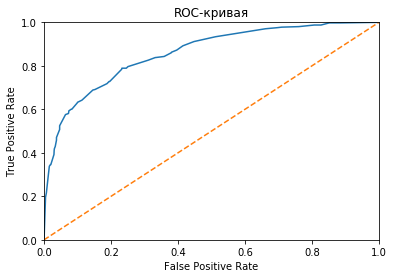

In [30]:
dtc_balanced.graph_roc()

- Показатель F1 - увеличился на 0.02 процента и стал 0.63
- ROC_AUC равен - 0.858

- ниже, хочу провести визуализацию, увидеть нагдяно деление 

#### <a name="4.1.3">4.1.3 Визуализация модели</a>

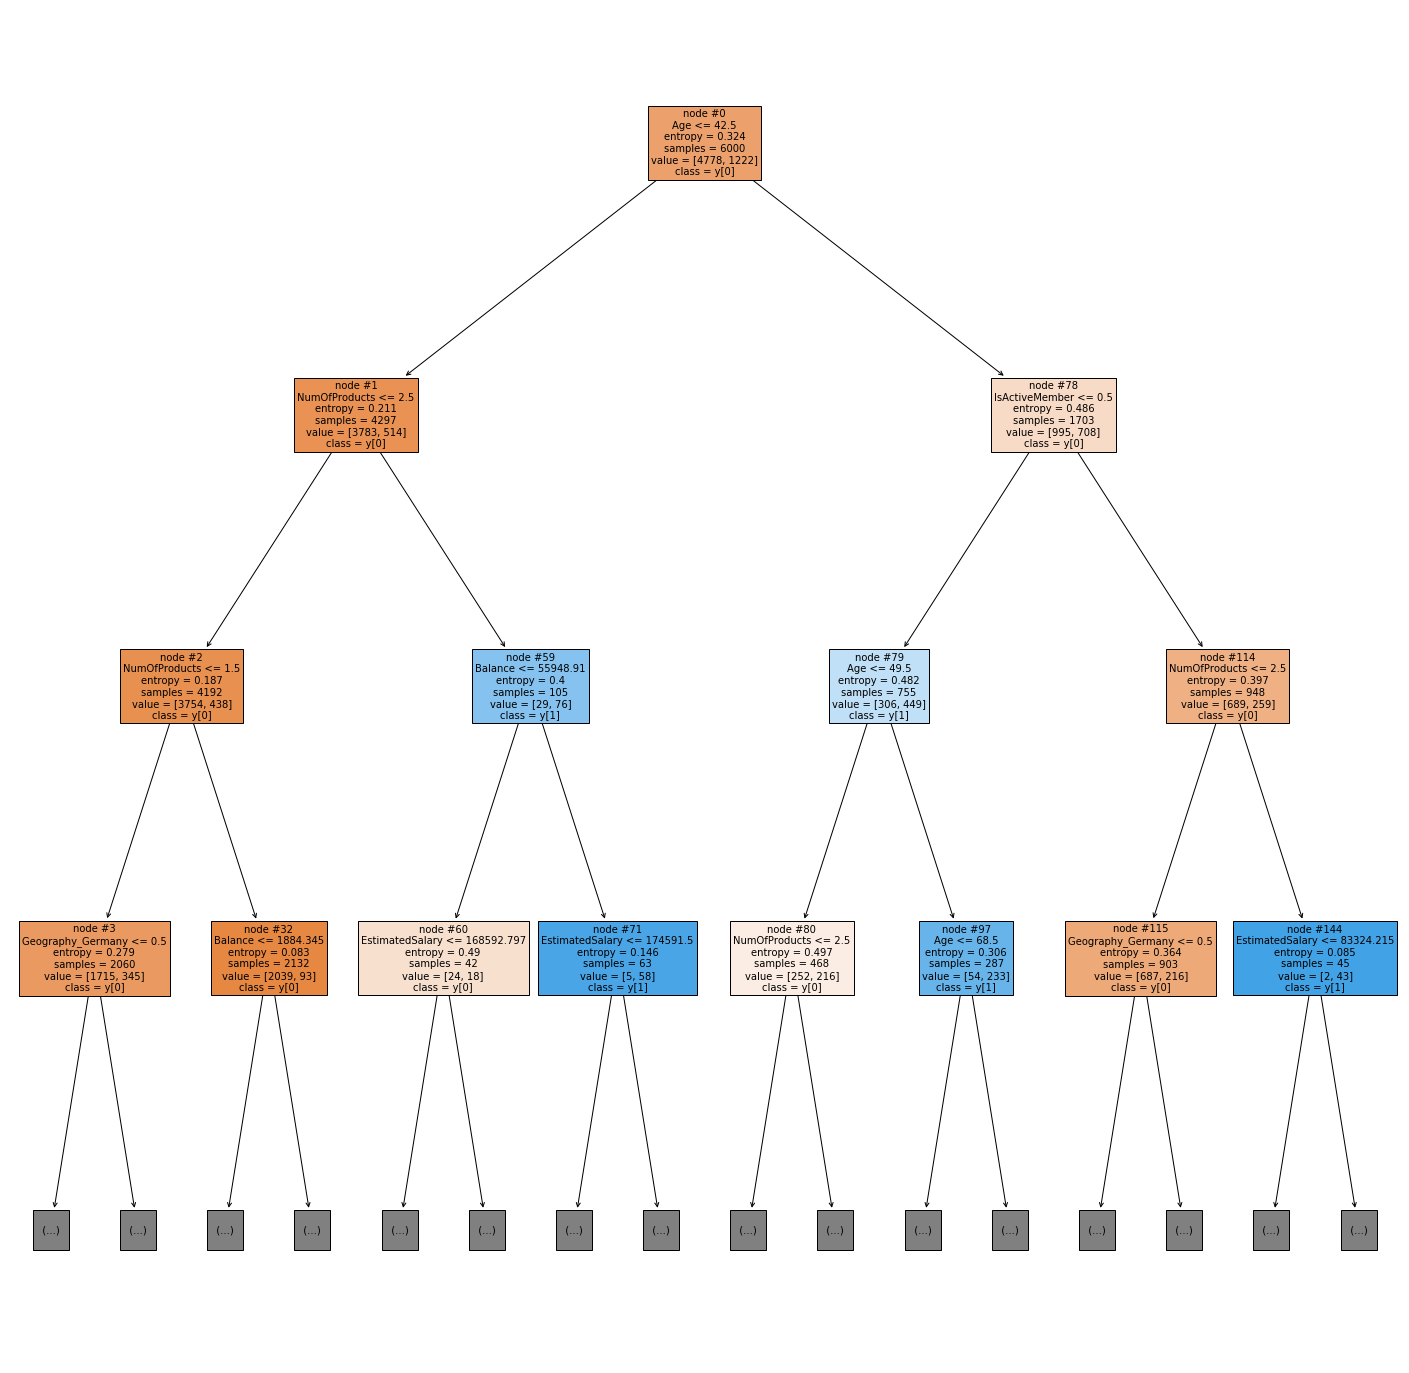

In [31]:
fig, ax = plt.subplots(figsize=(25, 25))
plot_tree(dtc_balanced.model, fontsize=10, max_depth = 3, filled=True, node_ids = True, 
          feature_names = features_train.columns, class_names = True)
plt.show()

- за основу модель взяла деление по возрасту, как я и писал выше, только 10% клиентов младше 40 лет уходят. Модель начинает с самого вероятно показателя для 0.
- далее по делению количество продуктов банка - менее 2.5, так как 3 и 4 это высокая вероятность ухода клиента.

Модель примерно повторяет мой анализ данных выше.

### <a name="4.2">4.2 Случайный лес</a>

#### <a name="4.2.1">4.2.1 Несбалансированная модель</a>

In [32]:
rfc = Modeling(RandomForestClassifier(max_depth=15, n_estimators = 14, min_samples_split = 8, 
                                          min_samples_leaf = 1, random_state = 42))

In [33]:
print('best_f1_score =', rfc.f1_score)

best_f1_score = 0.6228070175438597


- На валидационной выборке модель случайный лес показала F1 - 0.623

#### <a name="4.2.2">4.2.2 Балансированная модель</a>

In [34]:
rfc_balanced = Balanced(RandomForestClassifier(max_depth=13, n_estimators = 40, random_state = 42))
rfc_balanced.updown('up', 1,  None, 0.4)

In [35]:
print('best_f1_score =', rfc_balanced.f1_score)

best_f1_score = 0.6340819022457067


In [36]:
rfc_balanced.score()

CONFUSION_MATRIX
-------------------------------------------------------------------------------------


array([[1483,  109],
       [ 168,  240]])

-------------------------------------------------------------------------------------
CLASSIFICATION_REPORT
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1592
           1       0.69      0.59      0.63       408

    accuracy                           0.86      2000
   macro avg       0.79      0.76      0.77      2000
weighted avg       0.86      0.86      0.86      2000

-------------------------------------------------------------------------------------
ROC_AUC равен - 0.8602979665484285


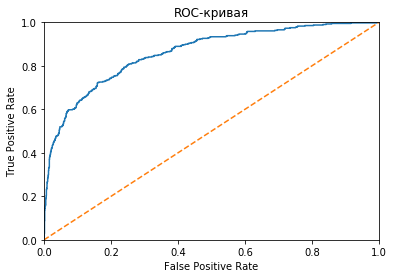

In [37]:
rfc_balanced.graph_roc()

- Показатель F1 - увеличился чуть более 1 процента и стал 0.634
- ROC_AUC равен - 0.86 - почти такой же как и в дереве решений
- Серьёзной разницы между этими двумя моделями не заметил, возможно не очень правильно настроил случайный лес

- для наглядности нарисую модель  

#### <a name="4.2.3">4.2.3 Визуализация модели</a>

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 20), dpi=900)
for index in range(0, 2):
    plot_tree(rfc_balanced.model.estimators_[index], max_depth=2, 
                   feature_names = features_train.columns, 
                   class_names=True,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 12)

### <a name="4.3">4.3 Логистическая регрессия</a>

#### <a name="4.3.1">4.3.1 Несбалансированная модель</a>

In [39]:
logreg = Modeling(LogisticRegression(C = 0.8, solver = 'newton-cg', max_iter = 200))

/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

In [40]:
print('best_f1_score =', logreg.f1_score)

best_f1_score = 0.32432432432432434


- На валидационной выборке логистическая регсессия показала F1 - 0.324. Слабовато. Без параметров, оценка еще ниже 0.11
- здесь и ниже в коде расчета я уже применил вместо циклов GridSearchCV.

#### <a name="4.3.2">4.3.2 Балансированная модель</a>

In [41]:
logreg_balanced = Balanced(LogisticRegression(C = 0.8, solver = 'newton-cg'))
logreg_balanced.updown('up', 2, 'scaler', 0.44)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

In [42]:
logreg_balanced.f1_score

0.5349611542730299

In [43]:
logreg_balanced.score()

CONFUSION_MATRIX
-------------------------------------------------------------------------------------


array([[1340,  252],
       [ 167,  241]])

-------------------------------------------------------------------------------------
CLASSIFICATION_REPORT
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1592
           1       0.49      0.59      0.53       408

    accuracy                           0.79      2000
   macro avg       0.69      0.72      0.70      2000
weighted avg       0.81      0.79      0.80      2000

-------------------------------------------------------------------------------------
ROC_AUC равен - 0.5031407035175879


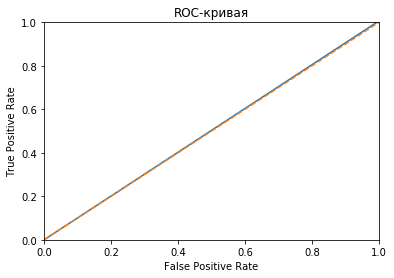

In [44]:
logreg_balanced.graph_roc()

- Показатель F1 - увеличился на 0.2 и стал 0.534. Я так понимаю, что работа с дисбалансом и scaler больше предназначена для этой модели.
- ROC_AUC равен - 0.5

### <a name="4.4"> 4.4 Градиентный бустинг</a>

#### <a name="4.4.1">4.4.1 Несбалансированная модель</a>

In [45]:
gbl = Modeling(GradientBoostingClassifier(random_state=42))

In [46]:
gbl.f1_score

0.6266471449487555

- На валидационной выборке модель градиентный бустинг показала F1 - 0.627. Это без параметров, с параметрами можно добрать 0.633. 

#### <a name="4.4.2">4.4.2 Балансированная модель</a>

In [47]:
gbl_balanced = Balanced(GradientBoostingClassifier(random_state=42))
gbl_balanced.updown('up', 2, None, 0.529)

In [48]:
gbl_balanced.f1_score

0.6606683804627249

In [49]:
gbl_balanced.score()

CONFUSION_MATRIX
-------------------------------------------------------------------------------------


array([[1479,  113],
       [ 151,  257]])

-------------------------------------------------------------------------------------
CLASSIFICATION_REPORT
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1592
           1       0.69      0.63      0.66       408

    accuracy                           0.87      2000
   macro avg       0.80      0.78      0.79      2000
weighted avg       0.86      0.87      0.87      2000

-------------------------------------------------------------------------------------
ROC_AUC равен - 0.8802830020199034


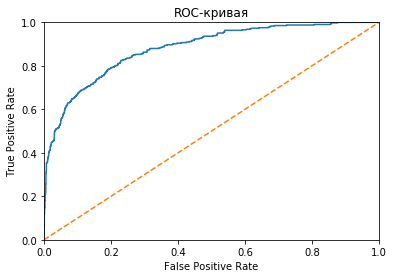

In [50]:
gbl_balanced.graph_roc()

- Показатель F1 - увеличился на 0.04 и стал 0.66. 
- ROC_AUC равен - 0.88

### <a name="4.5">4.5 CatBoost</a>

- ну и надо попробывать расхваленный Глебом CatBoost.
- попробую его без настроек, базовый вариант

#### <a name="4.5.1">4.5.1 Несбалансированная модель</a>

In [51]:
catboost = Modeling(CatBoostClassifier(random_state=42))

Learning rate set to 0.027819
0:	learn: 0.6698521	total: 59.9ms	remaining: 59.9s
1:	learn: 0.6502772	total: 69ms	remaining: 34.4s
2:	learn: 0.6328971	total: 83.9ms	remaining: 27.9s
3:	learn: 0.6136409	total: 94.1ms	remaining: 23.4s
4:	learn: 0.5959981	total: 177ms	remaining: 35.2s
5:	learn: 0.5808248	total: 187ms	remaining: 31s
6:	learn: 0.5657394	total: 272ms	remaining: 38.6s
7:	learn: 0.5513174	total: 283ms	remaining: 35.2s
8:	learn: 0.5406771	total: 295ms	remaining: 32.5s
9:	learn: 0.5291232	total: 374ms	remaining: 37s
10:	learn: 0.5178371	total: 383ms	remaining: 34.5s
11:	learn: 0.5074177	total: 469ms	remaining: 38.6s
12:	learn: 0.4976645	total: 480ms	remaining: 36.5s
13:	learn: 0.4900270	total: 490ms	remaining: 34.5s
14:	learn: 0.4815159	total: 572ms	remaining: 37.6s
15:	learn: 0.4724409	total: 581ms	remaining: 35.7s
16:	learn: 0.4659487	total: 667ms	remaining: 38.6s
17:	learn: 0.4586766	total: 681ms	remaining: 37.1s
18:	learn: 0.4532362	total: 764ms	remaining: 39.4s
19:	learn: 0.

In [52]:
catboost.f1_score

0.60932944606414

#### <a name="4.5.2">4.5.2 Балансированная модель</a>

In [53]:
catboost_balanced = Balanced(CatBoostClassifier(random_state=42))
catboost_balanced.updown('up', 1, None, 0.43)

Learning rate set to 0.027819
0:	learn: 0.6698521	total: 4.55ms	remaining: 4.54s
1:	learn: 0.6502772	total: 8.46ms	remaining: 4.22s
2:	learn: 0.6328971	total: 12.4ms	remaining: 4.12s
3:	learn: 0.6136409	total: 16.2ms	remaining: 4.03s
4:	learn: 0.5959981	total: 70.2ms	remaining: 14s
5:	learn: 0.5808248	total: 74.3ms	remaining: 12.3s
6:	learn: 0.5657394	total: 78.2ms	remaining: 11.1s
7:	learn: 0.5513174	total: 82.2ms	remaining: 10.2s
8:	learn: 0.5406771	total: 91.5ms	remaining: 10.1s
9:	learn: 0.5291232	total: 169ms	remaining: 16.7s
10:	learn: 0.5178371	total: 173ms	remaining: 15.5s
11:	learn: 0.5074177	total: 177ms	remaining: 14.6s
12:	learn: 0.4976645	total: 267ms	remaining: 20.3s
13:	learn: 0.4900270	total: 272ms	remaining: 19.1s
14:	learn: 0.4815159	total: 275ms	remaining: 18.1s
15:	learn: 0.4724409	total: 279ms	remaining: 17.2s
16:	learn: 0.4659487	total: 366ms	remaining: 21.1s
17:	learn: 0.4586766	total: 373ms	remaining: 20.3s
18:	learn: 0.4532362	total: 379ms	remaining: 19.6s
19:	

In [54]:
catboost_balanced.f1_score

0.6219839142091153

In [55]:
catboost_balanced.score()

CONFUSION_MATRIX
-------------------------------------------------------------------------------------


array([[1486,  106],
       [ 176,  232]])

-------------------------------------------------------------------------------------
CLASSIFICATION_REPORT
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1592
           1       0.69      0.57      0.62       408

    accuracy                           0.86      2000
   macro avg       0.79      0.75      0.77      2000
weighted avg       0.85      0.86      0.85      2000

-------------------------------------------------------------------------------------
ROC_AUC равен - 0.870062629323086


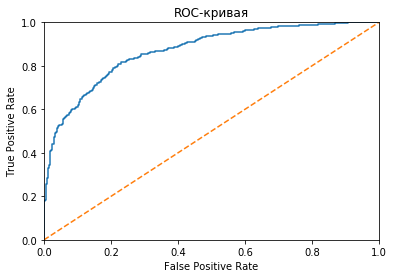

In [56]:
catboost_balanced.graph_roc()

- Показатель F1 - увеличился на 0.01 и стал 0.62. 
- ROC_AUC равен - 0.87

## Вывод:
- Лучшая модель на валидационной выборке это градиетный бустинг с её показателем F1_score на валидационной выборке 0.66.
- Работа с дисбалансом лучше всего себя оправдывает на модели логистической регрессии.

# <a name="5">5. Тестирование модели</a>

In [57]:
gbl_balanced.f1_score_test

0.6067114093959732

In [58]:
gbl_balanced.score_test()

CONFUSION_MATRIX
-------------------------------------------------------------------------------------


array([[1481,  112],
       [ 181,  226]])

-------------------------------------------------------------------------------------
CLASSIFICATION_REPORT
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.67      0.56      0.61       407

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.85      0.85      0.85      2000

-------------------------------------------------------------------------------------
ROC_AUC равен - 0.8637304484762112


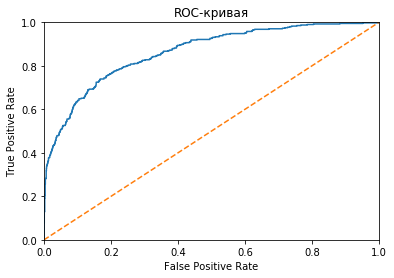

In [59]:
gbl_balanced.graph_roc_test()

- Фактически на тестовых данных, модель Градиентного бустинга оказалась переученной и мы получили снижением показателя F1_score с 0.66 до 0.606. Но порог в 0.59 пройден, значит цель выполнена. Roc_auc равен 0.864.

## <a name="6">Итоговый вывод:</a>
- Мы ознакомились с 5 моделями построения прогноза биноминальной классификации. Предварительно провели подготовительные работы:
- провели анализ входной информации, изучили взаимосвязи; 
- заполнив где необходимо пропуски; 
- удалили ненужные признаки.

В процессе обучения моделей для перебора Гиперпараметров использовали и циклы for, и gridsearc.  

Хотя тестовой выборке мы получили не наилучшие показатели по модели Градиентного бустинга F1_score - 0.606, в процессе обучения я сделал следующие для себя полезные выводы:
   - Дерево решений строится на простейшем анализе данных примерно таком, которое мы произвели при анализе информации;
   - Случайный лес, не даёт сильной прибавки в сравнении с деревом решений.
   - Работа с дисбалансом работает в полной мере только на логической регрессии;
   - Градиентный бустинг без параметров уже лучше чем все модели которые использовались;
   - GridSearcCv - работает по умолчанию с кроссвалидацией которая усредняет показатели оценки модели. 
